## Multi-class Classification

In this part,you will extend your previous implemention of logistic regression and apply it to one-vs-all classification

using ex3data1.mat

### 1.1 DataSet

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.io import loadmat
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format='svg'

Each training example is 20pixel by 20pixel unrolled into a 400-dimensional vector

This give us a 5000 x 400 matrix X

In [2]:
dataSet=loadmat('ex3data1.mat')

In [3]:
print(dataSet)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011', '__version__': '1.0', '__globals__': [], 'X': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'y': array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)}


### 1.2 Visualizing the data

In [4]:
def PlotDataX100(dataSet):
    """
    :param dataSet:
    """
    sampleIndex=np.random.choice(np.arange(dataSet['X'].shape[0]),100)
    sampleImage=dataSet['X'][sampleIndex,:]
    
    fig,ax=plt.subplots(nrows=10,ncols=10,sharey=True,sharex=True,figsize=(12,8))
    for row in range(10):
        for col in range(10):
            ax[row,col].matshow(np.array(sampleImage[row*10+col].reshape((20,20))),cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

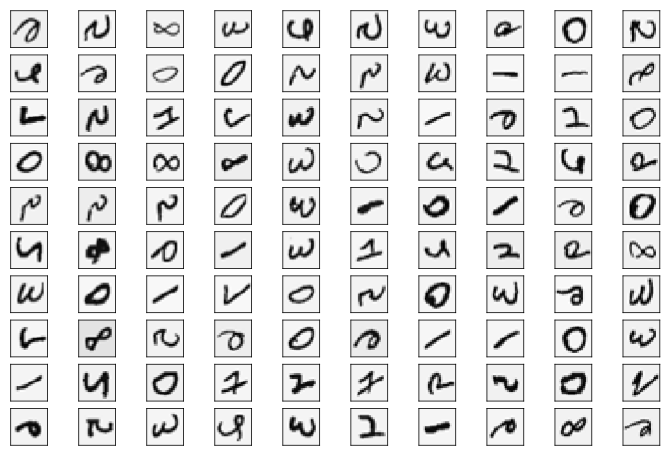

In [5]:
PlotDataX100(dataSet)

### 1.3 Vectorizing Logistic Regression

In this part,you will be using multiple one-vs-all logistic regression models to build a multi-class classifier

#### 1.3.1 Vectorizing the cost function

In [6]:
def sigmoid(z):
    """
    :param z:
    """
    return 1/(1+np.exp(-z))

In [7]:
def cost(theta,X,y):
    """
    :param theta:
    :param X:
    :param y:
    """
    
    theta=np.mat(theta)
    X=np.mat(X)
    y=np.mat(y)
    
    m=theta.shape[0]
    term1=np.multiply(-y,np.log(sigmoid(X)))
    term2=np.multiply(1-y,np.log(1-sigmoid(X)))
    
    return 1/(2*m)*np.sum(term1-term2)

#### 1.3.2 Vectorizing the gradient

In [8]:
def gradient(theta,X,y):
    """
    :param theta:
    :param X:
    :param y:
    """
    
    theta=np.mat(theta)
    X=np.mat(X)
    y=np.mat(y)
    
    m=theta.shape[0]
    parameters=int(theta.ravel().shape[1])
    g=np.zeros(parameters)
    
    error=sigmoid(X*theta.T)-y
    
    for j in range(parameters):
        term=np.multiply(error,X[:,j])
        
        g[0]=1/m*np.sum(term)
        
    return g

#### 1.3.3 Vectorizing regularized logistic regression

In [9]:
def costRe(theta,X,y,C):
    """
    :param theta:
    :param X:
    :param y:
    :param C: learning rate
    """
    theta=np.mat(theta)
    X=np.mat(X)
    y=np.mat(y)
    
    m=theta.shape[0]
    term1=np.multiply(-y,np.log(sigmoid(X*theta.T)))
    term2=np.multiply(1-y,np.log(1-sigmoid(X*theta.T)))
    reg=C/(2*m)*np.sum(np.power(theta[:,1:],2))
    
    return np.sum(term1-term2)/m+reg

In [10]:
def gradientRe(theta,X,y,C):
    """
    :param theta:
    :param X:
    :param y:
    :param C: learning rate
    """
    
    theta=np.mat(theta)
    X=np.mat(X)
    y=np.mat(y)
    
    m=theta.shape[0]
    parameters=int(theta.ravel().shape[1])
    g=np.zeros(parameters)
    
    error=sigmoid(theta*X.T)-y
    
    for j in range(parameters):
        term=np.multiply(error,X[:,j])
        if(j==0):
            g[0]=np.sum(term)
        else:
            g[j]=np.sum(term)+C/m*theta[:,j]
    return g

$\frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{i})-y^{(i)})x_{j}^{(i)}=\frac{1}{m}X^{T}(h\theta(x)-y)$

\begin{align}
  & Repeat\text{ }until\text{ }convergence\text{ }\!\!\{\!\!\text{ } \\ 
 & \text{     }{{\theta }_{0}}:={{\theta }_{0}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{_{0}}^{(i)}} \\ 
 & \text{     }{{\theta }_{j}}:={{\theta }_{j}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{j}^{(i)}}+\frac{\lambda }{m}{{\theta }_{j}} \\ 
 & \text{          }\!\!\}\!\!\text{ } \\ 
 & Repeat \\ 
\end{align}


In [11]:
def vecGradientRe(theta,X,y,C):
    """
    :param theta:
    :param X:
    :param y:
    :param C
    : learning rate
    """
    theta=np.mat(theta)
    X=np.mat(X)
    y=np.mat(y)
    
    parameters=int(theta.ravel().shape[1])
    error=sigmoid(X*theta.T)-y
    
    grad=((X.T*error)/len(X)).T+((C/len(X))*theta)
    
    grad[0,0]=np.sum(np.multiply(error,X[:,0]))/len(X)
    
    return np.array(grad).ravel()

### 1.4 One-vs-all Classification

In [12]:
from scipy.optimize import minimize

def OneVsAll(X,y,numLabels,C):
    rows=X.shape[0]
    parameters=X.shape[1]
    
    allTheta=np.zeros((numLabels,parameters+1))
    
    X=np.insert(X,0,values=np.ones(rows),axis=1)
    
    for i in range(1,numLabels+1):
        theta=np.zeros(parameters+1)
        y_i=np.array([1 if label==i else 0 for label in y])
        y_i=np.reshape(y_i,(rows,1))
        
        fmin=minimize(fun=costRe,x0=theta,args=(X,y_i,C),method='TNC',jac=vecGradientRe)
        allTheta[i-1,:]=fmin.x
        
    return allTheta

In [13]:
#Initial

#X,y
X=dataSet['X']
y=dataSet['y']

#numbers of labels
print(np.unique(dataSet['y']))
numLabels=10

#learning rate
C=1

[ 1  2  3  4  5  6  7  8  9 10]


In [14]:
%%time
allTheta=OneVsAll(X,y,numLabels,C)
allTheta

CPU times: user 14.4 s, sys: 1.62 s, total: 16 s
Wall time: 4.61 s


array([[-2.38271930e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.30447495e-03, -7.62371548e-10,  0.00000000e+00],
       [-3.18312017e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.46387429e-03, -5.08959133e-04,  0.00000000e+00],
       [-4.79741727e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.87108841e-05, -2.47526194e-07,  0.00000000e+00],
       ...,
       [-7.98743806e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.94588384e-05,  7.21025071e-06,  0.00000000e+00],
       [-4.57242880e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.33039090e-03,  1.30275261e-04,  0.00000000e+00],
       [-5.40568023e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16598780e-04,  7.88289072e-06,  0.00000000e+00]])

#### 1.4.1 One-vs-all Prediction

In [15]:
from sklearn.metrics import classification_report

In [16]:
def predict_all(X,all_theta):
    rows=X.shape[0]
    parameters=X.shape[1]
    numLabels=all_theta.shape[0]
    
    X=np.insert(X,0,values=np.ones(rows),axis=1)
    
    X=np.mat(X)
    all_theta=np.mat(all_theta)
    
    h=sigmoid(X*all_theta.T)
    
    h_argmax=np.argmax(h,axis=1) #by row
    
    h_argmax=h_argmax+1
    
    return h_argmax

In [17]:
yPred=predict_all(X,allTheta)
print(classification_report(dataSet['y'],yPred))

              precision    recall  f1-score   support

           1       0.95      0.99      0.97       500
           2       0.95      0.92      0.93       500
           3       0.95      0.91      0.93       500
           4       0.95      0.95      0.95       500
           5       0.92      0.92      0.92       500
           6       0.97      0.98      0.97       500
           7       0.95      0.95      0.95       500
           8       0.93      0.92      0.92       500
           9       0.92      0.92      0.92       500
          10       0.97      0.99      0.98       500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000

